In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [4]:
# 📌 **Load and Preprocess Dataset**
df = pd.read_csv("C:/Users/Kwaku Bonsu-Afrane/Desktop/Thesis/cleaned data/loan_repayment_dataset.csv")

In [5]:
df

,ID,ds,y,branch
0,1,2020-01-06,63.63,Kyeremase
1,1,2020-01-13,63.87,Kyeremase
2,1,2020-01-20,61.92,Kyeremase
3,1,2020-01-27,66.97,Kyeremase
4,1,2020-02-03,65.02,Kyeremase
...,...,...,...,...
12999995,50000,2024-11-25,79.21,Tokome
12999996,50000,2024-12-02,72.78,Tokome
12999997,50000,2024-12-09,71.53,Tokome
12999998,50000,2024-12-16,74.40,Tokome


In [6]:
# Convert date column to datetime format
df["ds"] = pd.to_datetime(df["ds"], errors='coerce')

In [7]:
# Drop rows with NaN values
df_selected = df[['ds', 'y']].dropna()

In [8]:
# Convert y to numeric for optimization
df_selected["y"] = pd.to_numeric(df_selected["y"], downcast="float")

In [9]:
# Aggregate data weekly (Resample)
df_selected = df_selected.set_index("ds").resample("W").mean().reset_index()

In [10]:
# Remove duplicate timestamps
df_selected = df_selected.sort_values(by="ds").drop_duplicates(subset="ds", keep="last")

In [11]:
# Check dataset information
print(df_selected.info())
print(df_selected.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      260 non-null    datetime64[ns]
 1   y       260 non-null    float32       
dtypes: datetime64[ns](1), float32(1)
memory usage: 3.2 KB
None
          ds          y
0 2020-01-12  61.517151
1 2020-01-19  63.421200
2 2020-01-26  65.235779
3 2020-02-02  66.987167
4 2020-02-09  68.600449


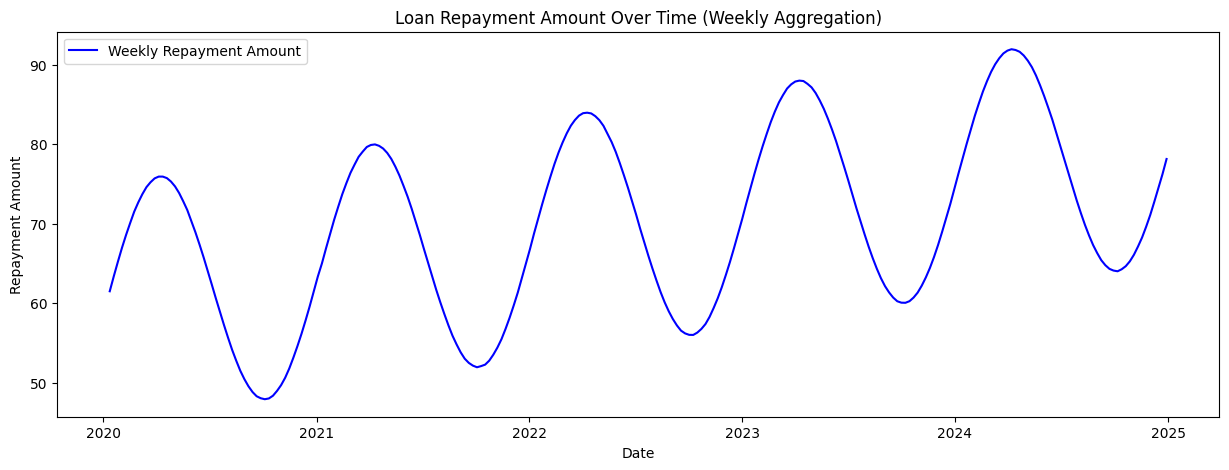

In [12]:
# 📊 **Plot Loan Repayment Over Time**
plt.figure(figsize=(15, 5))
plt.plot(df_selected["ds"], df_selected["y"], label="Weekly Repayment Amount", color="b")
plt.xlabel("Date")
plt.ylabel("Repayment Amount")
plt.title("Loan Repayment Amount Over Time (Weekly Aggregation)")
plt.legend()
plt.show()

In [13]:
# ✅ **Prepare Data for Benchmark Model**
df_weekly = df_selected.copy()

In [14]:
# Create Lag Feature (Previous Week's Repayment)
df_weekly["y_lag"] = df_weekly["y"].shift(1)

In [15]:
# Drop NaN values (first row will be NaN)
df_weekly = df_weekly.dropna()

In [16]:
# Split into Training (80%) and Validation (20%)
train_size = int(0.8 * len(df_weekly))
train_df = df_weekly[:train_size]
valid_df = df_weekly[train_size:]

In [17]:
# Extract Features (X) & Target (y)
X_train, y_train = train_df["y_lag"], train_df["y"]
X_valid, y_valid = valid_df["y_lag"], valid_df["y"]

In [ ]:
# Train OLS Regression Model
X_train = sm.add_constant(X_train)  # Add intercept term
ols_model = sm.OLS(y_train, X_train).fit()

In [19]:
# Print OLS Model Summary
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                 1.448e+04
Date:                Fri, 21 Mar 2025   Prob (F-statistic):          3.99e-192
Time:                        13:37:38   Log-Likelihood:                -343.06
No. Observations:                 207   AIC:                             690.1
Df Residuals:                     205   BIC:                             696.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5391      0.568      0.949      0.3

In [20]:
# Make Predictions
X_valid = sm.add_constant(X_valid)  # Add intercept term
y_pred_train = ols_model.predict(X_train)
y_pred_valid = ols_model.predict(X_valid)

In [21]:
# Evaluate Model Performance
mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)

mae_valid = mean_absolute_error(y_valid, y_pred_valid)
rmse_valid = mean_squared_error(y_valid, y_pred_valid, squared=False)

print(f"Train MAE: {mae_train:.4f}, Train RMSE: {rmse_train:.4f}")
print(f"Valid MAE: {mae_valid:.4f}, Valid RMSE: {rmse_valid:.4f}")

Train MAE: 1.1414, Train RMSE: 1.2691
Valid MAE: 1.1419, Valid RMSE: 1.2716


In [22]:
# Forecast Future Loan Repayments (52 Weeks Ahead)
future_steps = 52
future_dates = pd.date_range(start=df_weekly["ds"].max(), periods=future_steps, freq="W")

In [23]:
# Use last known repayment as prediction for next period
future_forecast = []
prev_y = df_weekly["y"].iloc[-1]  # Last known repayment
for _ in range(future_steps):
    next_y = ols_model.params[0] + ols_model.params[1] * prev_y
    future_forecast.append(next_y)
    prev_y = next_y  # Update previous value

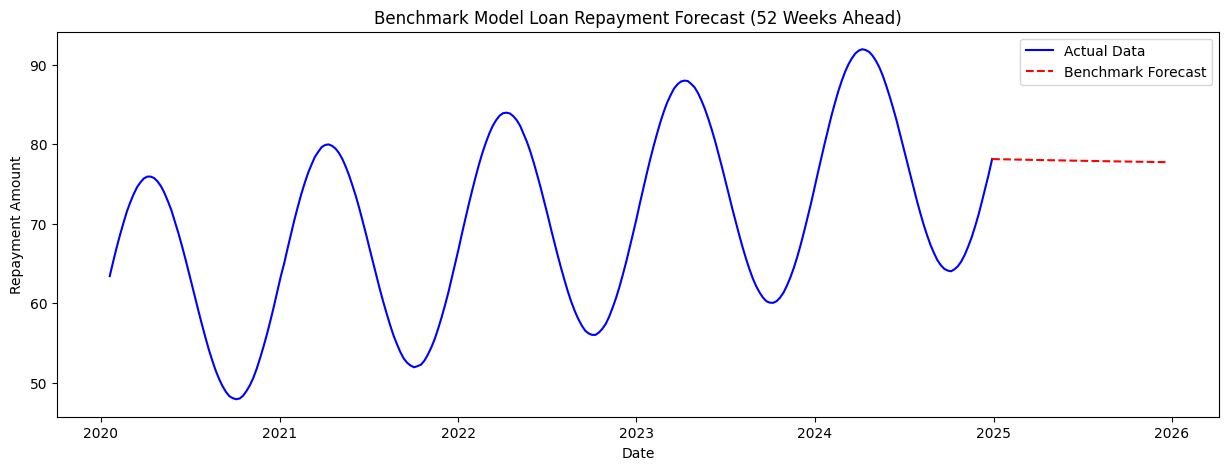

In [24]:
# Plot Forecast vs Actual Data
plt.figure(figsize=(15, 5))
plt.plot(df_weekly["ds"], df_weekly["y"], label="Actual Data", color="blue")
plt.plot(future_dates, future_forecast, label="Benchmark Forecast", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Repayment Amount")
plt.title("Benchmark Model Loan Repayment Forecast (52 Weeks Ahead)")
plt.legend()
plt.show()

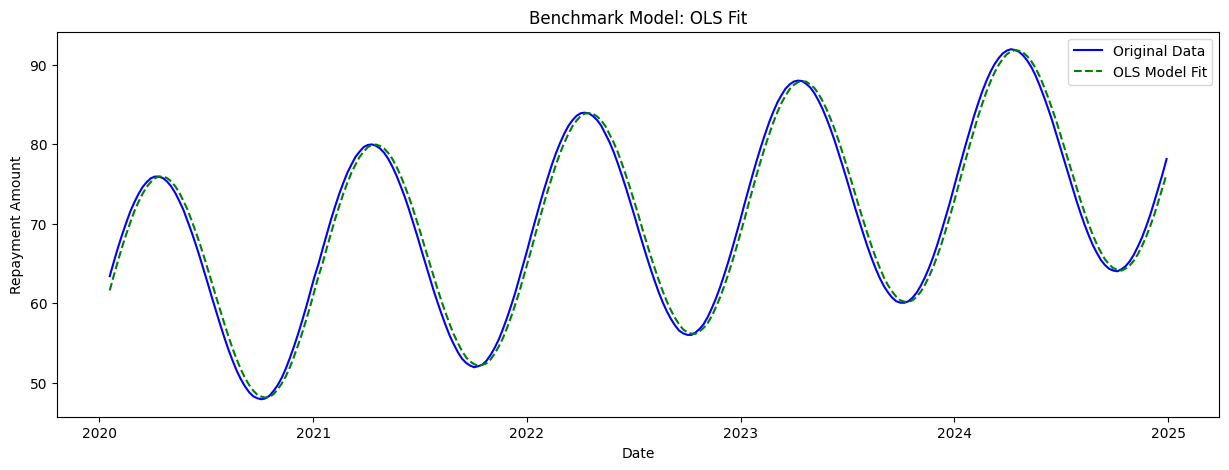

In [25]:
# 📊 **Trend and Seasonality Analysis**
plt.figure(figsize=(15, 5))
plt.plot(df_weekly["ds"], df_weekly["y"], label="Original Data", color="blue")
plt.plot(df_weekly["ds"], ols_model.predict(sm.add_constant(df_weekly["y_lag"])), label="OLS Model Fit", color="green", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Repayment Amount")
plt.title("Benchmark Model: OLS Fit")
plt.legend()
plt.show()